225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9923 - loss: 0.0302
Model loaded successfully with accuracy: 99.15%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


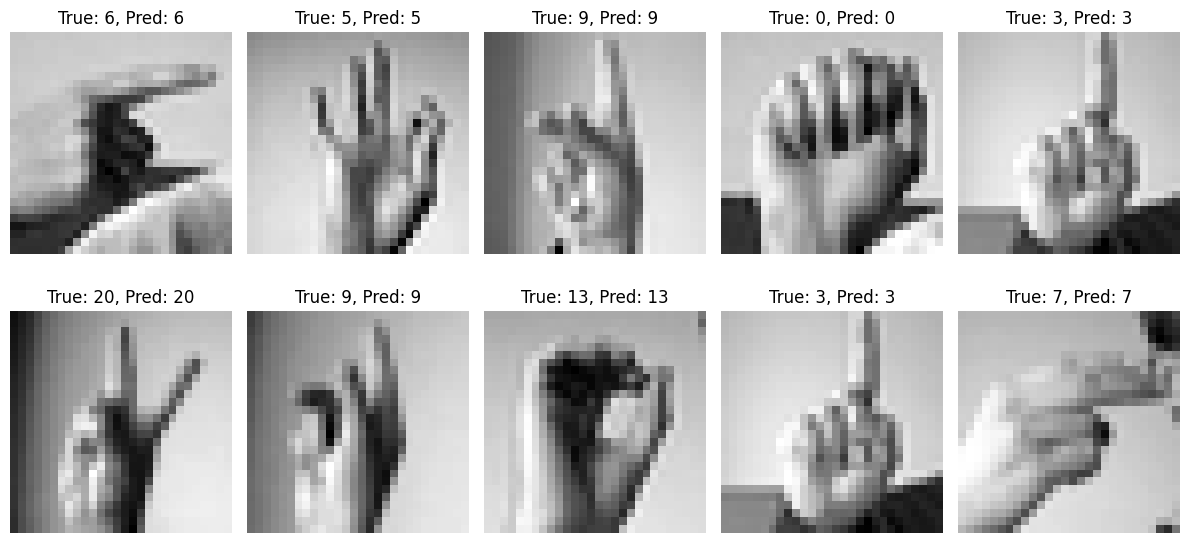

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from keras.models import load_model

# Cargar el modelo guardado
model = load_model('sign_language_model.h5')

# Cargar los datos de prueba
test_df = pd.read_csv('datasets/sign_mnist_test.csv')
test_label = test_df['label']
X_test = test_df.drop(['label'], axis=1).values.reshape(-1, 28, 28, 1) / 255.0

# Convertir etiquetas a formato one-hot
lb = LabelBinarizer()
y_test = lb.fit_transform(test_label)

# Evaluar el modelo
loss, acc = model.evaluate(X_test, y_test)
print(f'Model loaded successfully with accuracy: {acc*100:.2f}%')

# Predecir y mostrar algunas imágenes con sus predicciones
predictions = model.predict(X_test[:10])
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test[:10], axis=1)

# Mostrar las primeras 10 imágenes con sus etiquetas verdaderas y predichas
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()
for img, ax, true, pred in zip(X_test[:10], axes, true_classes, predicted_classes):
    ax.imshow(img.reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(f'True: {true}, Pred: {pred}')
plt.tight_layout()
plt.show()


In [3]:
import cv2
import mediapipe as mp
import numpy as np
import time
from keras.models import load_model

# Cargar el modelo de detección de manos de MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()

# Cargar el modelo de clasificación de señas
model = load_model('sign_language_model1.h5')

# Configurar la cámara
cap = cv2.VideoCapture(0)

# Crear el mapeo de clases a letras
classes = [chr(i) for i in range(ord('A'), ord('Z') + 1) if i not in [ord('G'), ord('J'), ord('X'), ord('S'), ord('Z')]]
assert len(classes) == 21, "El número de clases no coincide con el número esperado de 21 clases."

def get_hand_bounding_box(image, hand_landmarks):
    h, w, _ = image.shape
    x_min, y_min = w, h
    x_max, y_max = 0, 0
    
    for lm in hand_landmarks.landmark:
        x, y = int(lm.x * w), int(lm.y * h)
        if x < x_min:
            x_min = x
        if y < y_min:
            y_min = y
        if x > x_max:
            x_max = x
        if y > y_max:
            y_max = y

    return (x_min, y_min, x_max, y_max)

# Variables para la detección y cooldown
last_detection_time = time.time()
last_move_time = time.time()
detection_interval = 3  # segundos

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    current_time = time.time()
    
    # Convertir la imagen a RGB
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Detectar manos en la imagen
    results = hands.process(image)
    
    if results.multi_hand_landmarks:
        last_detection_time = current_time
        for hand_landmarks in results.multi_hand_landmarks:
            # Obtener el cuadro delimitador de la mano
            bbox = get_hand_bounding_box(image, hand_landmarks)
            
            # Recortar la imagen de la mano
            hand_image = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
            hand_image = cv2.resize(hand_image, (28, 28))
            hand_image = cv2.cvtColor(hand_image, cv2.COLOR_RGB2GRAY)
            hand_image = hand_image.reshape(1, 28, 28, 1) / 255.0
            
            # Clasificar la seña cada 3 segundos
            if (current_time - last_move_time) >= detection_interval:
                last_move_time = current_time
                predictions = model.predict(hand_image)
                class_id = np.argmax(predictions)
                confidence = predictions[0][class_id]
                
                # Verificar que class_id esté dentro del rango de classes
                if class_id < len(classes):
                    letter = classes[class_id]
                    # Mostrar el resultado
                    
                else:
                    print(f'Error: class_id {class_id} está fuera del rango de la lista classes.')
    cv2.putText(frame, f'Letter: {letter}, Confidence: {confidence:.2f}', (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
    
    # Verificar si ha pasado más de 10 segundos sin detectar movimientos
    if (current_time - last_detection_time) > 10:
        print("No se detecta movimiento por más de 10 segundos. Deteniendo la detección.")
        break
    
    # Mostrar la imagen
    cv2.imshow('Hand Sign Detection', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
